# Analyze Machine Learning Results

In [1]:
# global imports
# pyspark
import pyspark
from pyspark.sql.session import SparkSession
import pyspark.sql.functions as W
# visualizations
import matplotlib.pyplot as plt
from wordcloud import WordCloud

spark = SparkSession.builder.getOrCreate()

In [2]:
cloud = WordCloud()
# function for creating a word cloud
def createWordCloud(dic):
    plt.figure()
    cloud.generate_from_frequencies(dic)
    plt.imshow(cloud)
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.show()

# Import Data

In [3]:
# import data
%store -r ml_dfs

In [4]:
# linear support vector machine results
lsvc_test = spark.createDataFrame(ml_dfs[0])
lsvc_test.show(2)

+--------------------+---------+--------------------+----------+
|           count_vec|label_idx|       rawPrediction|prediction|
+--------------------+---------+--------------------+----------+
|(349,[2,58,118,12...|      0.0|[0.76933931432304...|       0.0|
|(349,[0,4,134,186...|      1.0|[-0.4556061437591...|       1.0|
+--------------------+---------+--------------------+----------+
only showing top 2 rows



In [5]:
# all machine learning results
results = spark.createDataFrame(ml_dfs[1])
results.show(2)

+--------------------+---------+-------+---+--------+-------+--------+----------+----------+---------+
|           count_vec|label_idx|rf_pred| id|gbt_pred|nb_pred|ols_pred|lasso_pred|ridge_pred|lsvc_pred|
+--------------------+---------+-------+---+--------+-------+--------+----------+----------+---------+
|(349,[2,58,118,12...|      0.0|    0.0|  1|     0.0|    0.0|     0.0|       0.0|       0.0|      0.0|
|(349,[0,4,134,186...|      1.0|    0.0|  2|     1.0|    1.0|     1.0|       1.0|       1.0|      1.0|
+--------------------+---------+-------+---+--------+-------+--------+----------+----------+---------+
only showing top 2 rows



In [6]:
# import data
%store -r dfs

In [7]:
# import vocabulary
vocab = dfs[3]

# Misclassified Observations by Every Algorithm

In [8]:
# create dataframe of observations that were always misclassified
misclassified = results.where((W.col('label_idx')!=W.col('rf_pred')) &
                             (W.col('label_idx')!=W.col('gbt_pred')) &
                             (W.col('label_idx')!=W.col('nb_pred')) &
                             (W.col('label_idx')!=W.col('ols_pred')) &
                             (W.col('label_idx')!=W.col('lasso_pred')) &
                             (W.col('label_idx')!=W.col('ridge_pred')) &
                             (W.col('label_idx')!=W.col('lsvc_pred')))
# output dataframe
misclassified.show(2)

+--------------------+---------+-------+---+--------+-------+--------+----------+----------+---------+
|           count_vec|label_idx|rf_pred| id|gbt_pred|nb_pred|ols_pred|lasso_pred|ridge_pred|lsvc_pred|
+--------------------+---------+-------+---+--------+-------+--------+----------+----------+---------+
|(349,[1,110,280,3...|      1.0|    0.0|  3|     0.0|    0.0|     0.0|       0.0|       0.0|      0.0|
|(349,[2,11,13,15,...|      1.0|    0.0| 20|     0.0|    0.0|     0.0|       0.0|       0.0|      0.0|
+--------------------+---------+-------+---+--------+-------+--------+----------+----------+---------+
only showing top 2 rows



## Examine Misclassified Labels

In [9]:
# get total counts
total_counts = results.groupby('label_idx').count()
total_counts.show()

+---------+-----+
|label_idx|count|
+---------+-----+
|      0.0| 2779|
|      1.0| 1593|
+---------+-----+



In [10]:
# get proportion misclassified
mis_counts = misclassified.groupby('label_idx').count()
mis_counts = mis_counts.withColumnRenamed('label_idx','label_idx2')
mis_counts = mis_counts.withColumnRenamed('count','miscount')
mis_counts = mis_counts.join(total_counts,total_counts.label_idx==mis_counts.label_idx2)
mis_counts = mis_counts.drop('label_idx2')
mis_counts = mis_counts.withColumn('proportion',W.col('miscount')/W.col('count'))
mis_counts.show()

+--------+---------+-----+--------------------+
|miscount|label_idx|count|          proportion|
+--------+---------+-----+--------------------+
|      19|      0.0| 2779|0.006836991723641598|
|     349|      1.0| 1593| 0.21908349026993096|
+--------+---------+-----+--------------------+



## Examine Misclassified Words for Positive Tweets

In [11]:
# function for creating key and value pair of a row
def key_val(row):
    new_row = [(i,row[i]) for i in range(len(row))]
    return new_row

In [12]:
# create dictionary of indices and word counts
mis_pos_counts_dict = misclassified.where(W.col('label_idx')==1)\
                                   .select('count_vec').rdd\
                                   .map(lambda row: row.count_vec.toArray())\
                                   .map(lambda row: key_val(row))\
                                   .flatMap(lambda row: row)\
                                   .reduceByKey(lambda x,y: x+y)\
                                   .mapValues(lambda x: int(x))\
                                   .collectAsMap()

In [13]:
# update the dictionary so the keys correspond to words
for i in range(0,len(vocab)):
    mis_pos_counts_dict[vocab[i]] = mis_pos_counts_dict.pop(i)

In [14]:
# get dictionary with values greater than 0
mis_pos_clean = {}
for k in mis_pos_counts_dict.keys():
    if mis_pos_counts_dict[k] > 0:
        mis_pos_clean[k] = mis_pos_counts_dict[k]

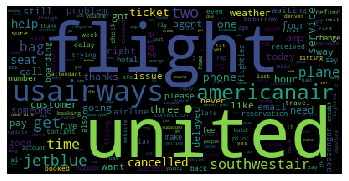

In [15]:
# create word cloud
createWordCloud(mis_pos_clean)

## Examine Misclassified Words for Negative Tweets

In [16]:
# create dictionary of indices and word counts
mis_neg_counts_dict = misclassified.where(W.col('label_idx')==0)\
                                   .select('count_vec').rdd\
                                   .map(lambda row: row.count_vec.toArray())\
                                   .map(lambda row: key_val(row))\
                                   .flatMap(lambda row: row)\
                                   .reduceByKey(lambda x,y: x+y)\
                                   .mapValues(lambda x: int(x))\
                                   .collectAsMap()

In [17]:
# update the dictionary so the keys correspond to words
for i in range(0,len(vocab)):
    mis_neg_counts_dict[vocab[i]] = mis_neg_counts_dict.pop(i)

In [18]:
# get dictionary with values greater than 0
mis_neg_clean = {}
for k in mis_neg_counts_dict.keys():
    if mis_neg_counts_dict[k] > 0:
        mis_neg_clean[k] = mis_neg_counts_dict[k]

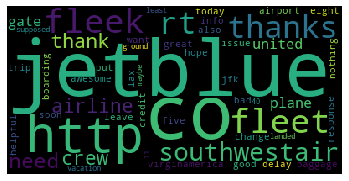

In [19]:
# create word cloud
createWordCloud(mis_neg_clean)

## Unique Misclassified Positive Words

In [20]:
# get unique positive words
mis_pos_unique = {}
for k in mis_pos_clean.keys():
    if k not in mis_neg_clean.keys():
        mis_pos_unique[k] = mis_pos_clean[k]

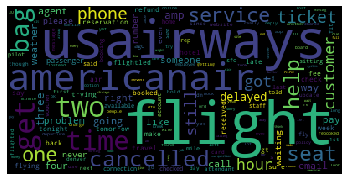

In [21]:
# create word cloud
createWordCloud(mis_pos_unique)

## Unique Misclassified Negative Words

In [22]:
# get unique negative words
mis_neg_unique = {}
for k in mis_neg_clean.keys():
    if k not in mis_pos_clean.keys():
        mis_neg_unique[k] = mis_neg_clean[k]

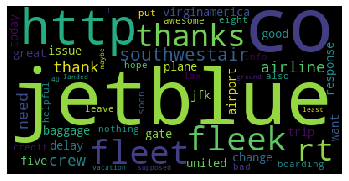

In [23]:
# create word cloud
createWordCloud(mis_neg_clean)

# Correctly Classified Observations by Every Algorithm

In [24]:
# create dataframe of observations that were always misclassified
correct = results.where((W.col('label_idx')==W.col('rf_pred')) &
                             (W.col('label_idx')==W.col('gbt_pred')) &
                             (W.col('label_idx')==W.col('nb_pred')) &
                             (W.col('label_idx')==W.col('ols_pred')) &
                             (W.col('label_idx')==W.col('lasso_pred')) &
                             (W.col('label_idx')==W.col('ridge_pred')) &
                             (W.col('label_idx')==W.col('lsvc_pred')))
# output dataframe
correct.show(2)

+--------------------+---------+-------+---+--------+-------+--------+----------+----------+---------+
|           count_vec|label_idx|rf_pred| id|gbt_pred|nb_pred|ols_pred|lasso_pred|ridge_pred|lsvc_pred|
+--------------------+---------+-------+---+--------+-------+--------+----------+----------+---------+
|(349,[2,58,118,12...|      0.0|    0.0|  1|     0.0|    0.0|     0.0|       0.0|       0.0|      0.0|
|(349,[1,6,13,18,2...|      0.0|    0.0|  4|     0.0|    0.0|     0.0|       0.0|       0.0|      0.0|
+--------------------+---------+-------+---+--------+-------+--------+----------+----------+---------+
only showing top 2 rows



## Examine Correctly Classified Labels

In [25]:
# get proportion misclassified
correct_counts = correct.groupby('label_idx').count()
correct_counts = correct_counts.withColumnRenamed('label_idx','label_idx2')
correct_counts = correct_counts.withColumnRenamed('count','miscount')
correct_counts = correct_counts.join(total_counts,total_counts.label_idx==correct_counts.label_idx2)
correct_counts = correct_counts.drop('label_idx2')
correct_counts = correct_counts.withColumn('proportion',W.col('miscount')/W.col('count'))
correct_counts.show()

+--------+---------+-----+-------------------+
|miscount|label_idx|count|         proportion|
+--------+---------+-----+-------------------+
|    2130|      0.0| 2779| 0.7664627563871896|
|     214|      1.0| 1593|0.13433772755806653|
+--------+---------+-----+-------------------+



## Examine Correctly Classified Words for Positive Tweets

In [26]:
# create dictionary of indices and word counts
correct_pos_counts_dict = correct.where(W.col('label_idx')==1)\
                                 .select('count_vec').rdd\
                                 .map(lambda row: row.count_vec.toArray())\
                                 .map(lambda row: key_val(row))\
                                 .flatMap(lambda row: row)\
                                 .reduceByKey(lambda x,y: x+y)\
                                 .mapValues(lambda x: int(x))\
                                 .collectAsMap()

In [27]:
# update the dictionary so the keys correspond to words
for i in range(0,len(vocab)):
    correct_pos_counts_dict[vocab[i]] = correct_pos_counts_dict.pop(i)

In [28]:
# get dictionary with values greater than 0
correct_pos_clean = {}
for k in correct_pos_counts_dict.keys():
    if correct_pos_counts_dict[k] > 0:
        correct_pos_clean[k] = correct_pos_counts_dict[k]

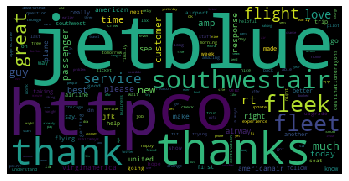

In [29]:
# create word cloud
createWordCloud(correct_pos_clean)

## Examine Correctly Classified Words for Negative Tweets

In [30]:
# create dictionary of indices and word counts
correct_neg_counts_dict = correct.where(W.col('label_idx')==0)\
                                 .select('count_vec').rdd\
                                 .map(lambda row: row.count_vec.toArray())\
                                 .map(lambda row: key_val(row))\
                                 .flatMap(lambda row: row)\
                                 .reduceByKey(lambda x,y: x+y)\
                                 .mapValues(lambda x: int(x))\
                                 .collectAsMap()

In [31]:
# update the dictionary so the keys correspond to words
for i in range(0,len(vocab)):
    correct_neg_counts_dict[vocab[i]] = correct_neg_counts_dict.pop(i)

In [32]:
# get dictionary with values greater than 0
correct_neg_clean = {}
for k in correct_neg_counts_dict.keys():
    if correct_neg_counts_dict[k] > 0:
        correct_neg_clean[k] = correct_neg_counts_dict[k]

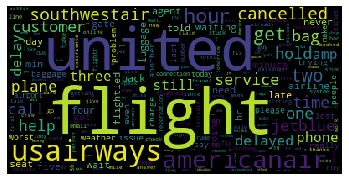

In [33]:
# create word cloud
createWordCloud(correct_neg_clean)

## Unique Correctly Classified Positive Words

In [34]:
# get unique positive words
correct_pos_unique = {}
for k in correct_pos_clean.keys():
    if k not in correct_neg_clean.keys():
        correct_pos_unique[k] = correct_pos_clean[k]

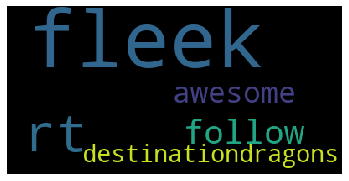

In [35]:
# create word cloud
createWordCloud(correct_pos_unique)

## Unique Correctly Classified Negative Words

In [36]:
# get unique negative words
correct_neg_unique = {}
for k in correct_neg_clean.keys():
    if k not in correct_pos_clean.keys():
        correct_neg_unique[k] = correct_neg_clean[k]

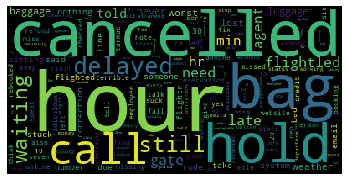

In [37]:
# create word cloud
createWordCloud(correct_neg_unique)